## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt torchtext==0.6.0 nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-24 10:57:32--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.03s   

2023-05-24 10:57:33 (367 MB/s) - ‘data.txt’ saved [12905334/12905334]



Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [3]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [4]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [5]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9248
Unique tokens in target (en) vocabulary: 6689


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 'полюбоваться',
 'motor',
 'красная',
 'яиц',
 'этажный',
 'hospitality',
 'ужины',
 'диснейленда',
 'тенистой']

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::1000]

['<unk>', 'russian', 'getting', 'catalan', 'margherita', 'step', 'massa']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[9]))

{'trg': ['a', 'flat', '-', 'screen', 'tv', 'is', 'offered', '.'], 'src': ['в', 'числе', 'удобств', 'телевизор', 'с', 'плоским', 'экраном', '.']}


Let's check the length distributions:

Length distribution in Train data


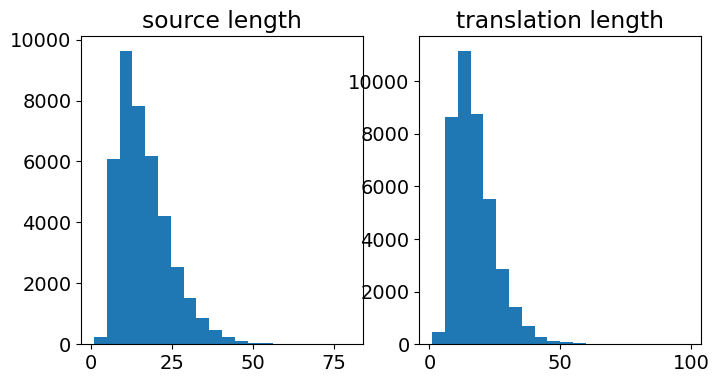

In [13]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


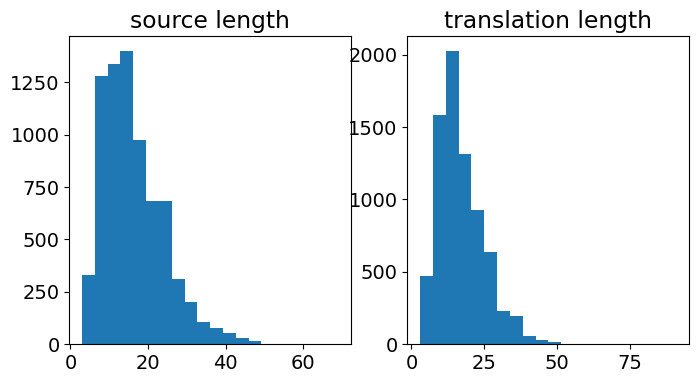

In [14]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda')

In [17]:
def _len_sort_key(x):
    return len(x.src)

In [18]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 55x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 62x128 (GPU 0)]
torch.Size([62, 128]) torch.Size([55, 128])


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [20]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [ ]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9197, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6738, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6738, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,892,370 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [22]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

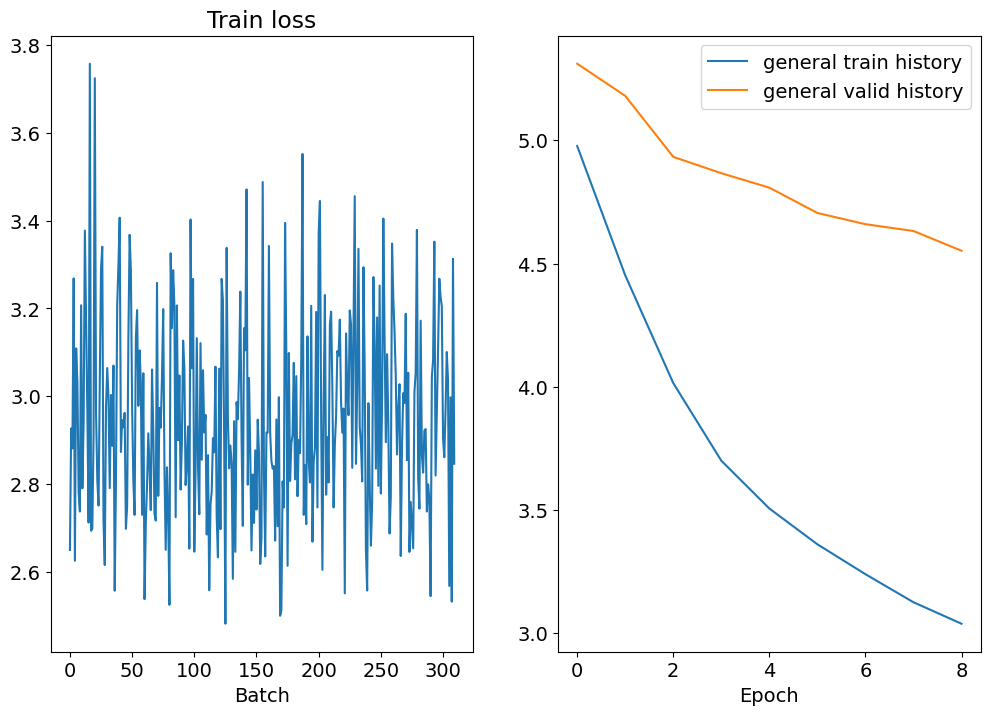

Epoch: 10 | Time: 2m 4s
	Train Loss: 2.948 | Train PPL:  19.060
	 Val. Loss: 4.513 |  Val. PPL:  91.226


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
# del utils

In [25]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [26]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: breakfast is served in the restaurant .
Generated: the restaurant , and and .

Original: you will find a 24 - hour front desk at the property .
Generated: and a 24 - hour front desk .



In [27]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [28]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:07,  8.01it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.584903664875677

### First approach (Attention)

In [ ]:
import attention_network
EncoderAttn = attention_network.EncoderAttn
Attention = attention_network.Attention
DecoderAttn = attention_network.DecoderAttn
Seq2SeqAttn = attention_network.Seq2SeqAttn

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
TRG_PAD_IDX = TRG.vocab.stoi['<pad>']
    
enc = EncoderAttn(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = Attention(HID_DIM, HID_DIM)
dec = DecoderAttn(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attention)

# dont forget to put the model to the right device
attn_model = Seq2SeqAttn(enc, dec, device).to(device)

In [ ]:
attn_model.apply(init_weights)

Seq2SeqAttn(
  (encoder): EncoderAttn(
    (embedding): Embedding(9245, 256)
    (rnn): LSTM(256, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttn(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (tanh): Tanh()
      (fc): Linear(in_features=512, out_features=1, bias=True)
      (softmax): Softmax(dim=0)
    )
    (embedding): Embedding(6707, 256)
    (rnn): GRU(768, 512, dropout=0.5)
    (out): Linear(in_features=1280, out_features=6707, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
print(f'The model has {count_parameters(attn_model):,} trainable parameters')

The model has 16,746,804 trainable parameters


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [ ]:
optimizer = optim.Adam(attn_model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

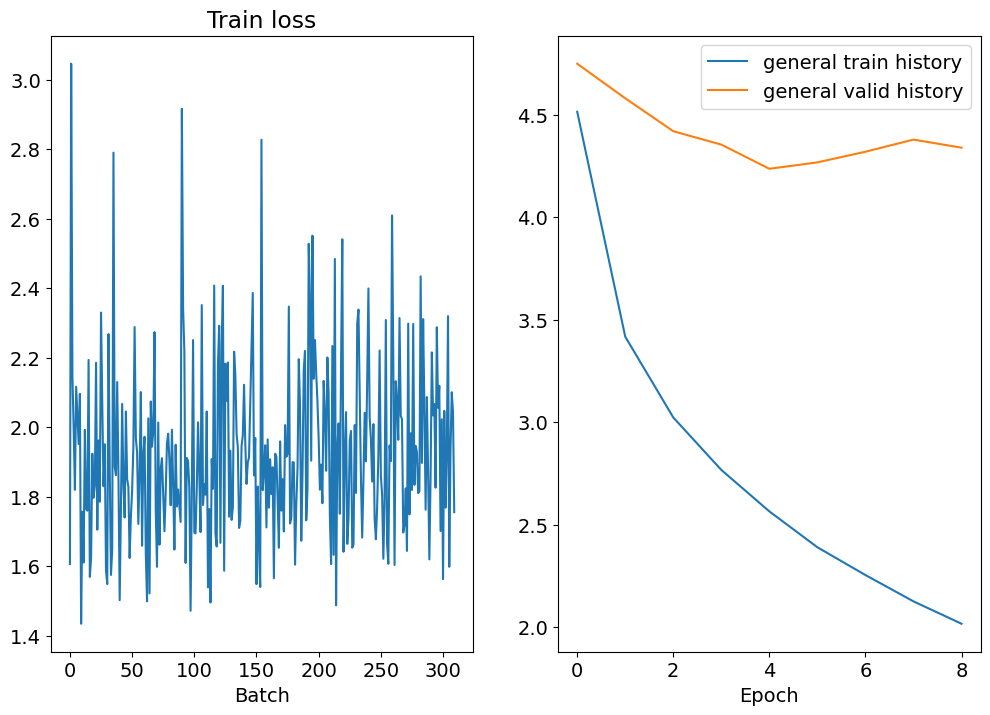

Epoch: 10 | Time: 3m 34s
	Train Loss: 1.929 | Train PPL:   6.880
	 Val. Loss: 4.406 |  Val. PPL:  81.917


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(attn_model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(attn_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(attn_model.state_dict(), 'tut1-attn_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
original_text = []
generated_text = []
attn_model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = attn_model(src, trg, 0)

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

59it [00:08,  6.77it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

28.010599110509656

As expected Attention showed good results, much better than base Encoder-Decoder Seq2Seq. As you can see, some overfitting are exist, and our loss in a pretty low level.

### Second approach (Transformer)

In [29]:
TRG_PAD_IDX = TRG.vocab.stoi['<pad>']
SRC_PAD_IDX = SRC.vocab.stoi['<pad>']

In [30]:
def generate_square_subsequent_mask(size):
  mask = (torch.triu(torch.ones((size, size), device=device)) == 1).transpose(0, 1)
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

In [31]:
def make_mask(src, trg):
  src_seq_len = src.shape[0]
  trg_seq_len = trg.shape[0]
  trg_mask = generate_square_subsequent_mask(trg_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)
  src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1)
  trg_padding_mask = (trg == TRG_PAD_IDX).transpose(0, 1)
  return src_mask, trg_mask, src_padding_mask, trg_padding_mask

In [32]:
import transformer
Seq2SeqTransformer = transformer.Seq2SeqTransformer

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 512
NHEAD = 8
FFN_HID_DIM = 512
ENC_N_LAYERS = 3
DEC_N_LAYERS = 3
TRG_PAD_IDX = TRG.vocab.stoi['<pad>']
    
transformer = Seq2SeqTransformer(ENC_N_LAYERS, DEC_N_LAYERS, EMB_DIM, NHEAD, INPUT_DIM, OUTPUT_DIM, FFN_HID_DIM)

for param in transformer.parameters():
  if param.dim() > 1:
    nn.init.xavier_uniform_(param)

transformer = transformer.to(device)

In [34]:
transformer.apply(init_weights)

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [35]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 24,216,097 trainable parameters


In [36]:
train_history = []
valid_history = []

N_EPOCHS = 20
# N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

In [37]:
optimizer = optim.Adam(transformer.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Let's make some changes in functions train and evaluate:

In [38]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        src_mask, trg_mask, src_padding_mask, trg_padding_mask = make_mask(src, trg)
        
        optimizer.zero_grad()
        
        output = model(src, trg, src_mask, trg_mask, src_padding_mask, trg_padding_mask, None)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            src_mask, trg_mask, src_padding_mask, trg_padding_mask = make_mask(src, trg)

            output = model(src, trg, src_mask, trg_mask, src_padding_mask, trg_padding_mask, None)

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

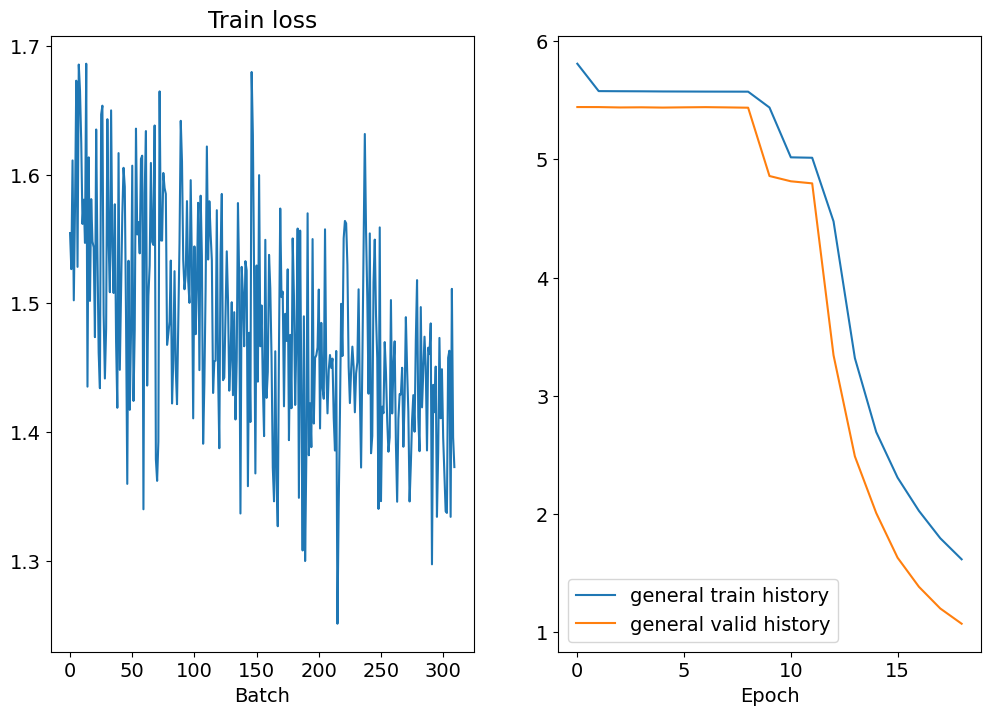

Epoch: 20 | Time: 1m 24s
	Train Loss: 1.482 | Train PPL:   4.401
	 Val. Loss: 0.951 |  Val. PPL:   2.589


In [40]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(transformer, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(transformer, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(transformer.state_dict(), 'tut1-cnn_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [41]:
original_text = []
generated_text = []
transformer.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        src_mask, trg_mask, src_padding_mask, trg_padding_mask = make_mask(src, trg)

        output = transformer(src, trg, src_mask, trg_mask, src_padding_mask, trg_padding_mask, None)

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:02, 23.72it/s]


In [42]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

49.88053542833184

We see that transformer performed way better than above models.

### Third approach (CNN model)

In [ ]:
import torch.nn.functional as F
import matplotlib.ticker as ticker

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9196
Unique tokens in target (en) vocabulary: 6646


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Batch size had to be made from a smaller condition just for this CNN model

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
import cnn_network
EncoderCNN = cnn_network.EncoderCNN
DecoderCNN = cnn_network.DecoderCNN
Seq2SeqCNN = cnn_network.Seq2SeqCNN

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 64
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
ENC_KERNEL_SIZE = 3
DEC_KERNEL_SIZE = 3
TRG_PAD_IDX = TRG.vocab.stoi['<pad>']

enc = EncoderCNN(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = DecoderCNN(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

# dont forget to put the model to the right device
cnn_model = Seq2SeqCNN(enc, dec).to(device)

In [ ]:
cnn_model.apply(init_weights)

Seq2SeqCNN(
  (encoder): EncoderCNN(
    (tok_embedding): Embedding(9196, 128)
    (pos_embedding): Embedding(100, 128)
    (emb2hid): Linear(in_features=128, out_features=64, bias=True)
    (hid2emb): Linear(in_features=64, out_features=128, bias=True)
    (convs): ModuleList(
      (0-3): 4 x Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): DecoderCNN(
    (tok_embedding): Embedding(6646, 128)
    (pos_embedding): Embedding(100, 128)
    (emb2hid): Linear(in_features=128, out_features=64, bias=True)
    (hid2emb): Linear(in_features=64, out_features=128, bias=True)
    (attn_hid2emb): Linear(in_features=64, out_features=128, bias=True)
    (attn_emb2hid): Linear(in_features=128, out_features=64, bias=True)
    (fc_out): Linear(in_features=128, out_features=6646, bias=True)
    (convs): ModuleList(
      (0-3): 4 x Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    )
    (dropout): Dropout(p=0.25, inplace

In [ ]:
print(f'The model has {count_parameters(cnn_model):,} trainable parameters')

The model has 3,158,070 trainable parameters


The number of epochs can be left the same as it was 10. More precisely, I initially tried to do it on 10 epochs, but CNN does not start very well, there may be memory problems, so I left one epoch in the end, especially since the result is already good.

In [ ]:
train_history = []
valid_history = []

# N_EPOCHS = 10
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

We should a little bit rewrite our train and evaluate functions:

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        
        output, _ = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
     
        loss = criterion(output, trg)   
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        if i >= 450:
            break
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.train()    
    
    model.eval()   
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg) 
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
optimizer = optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

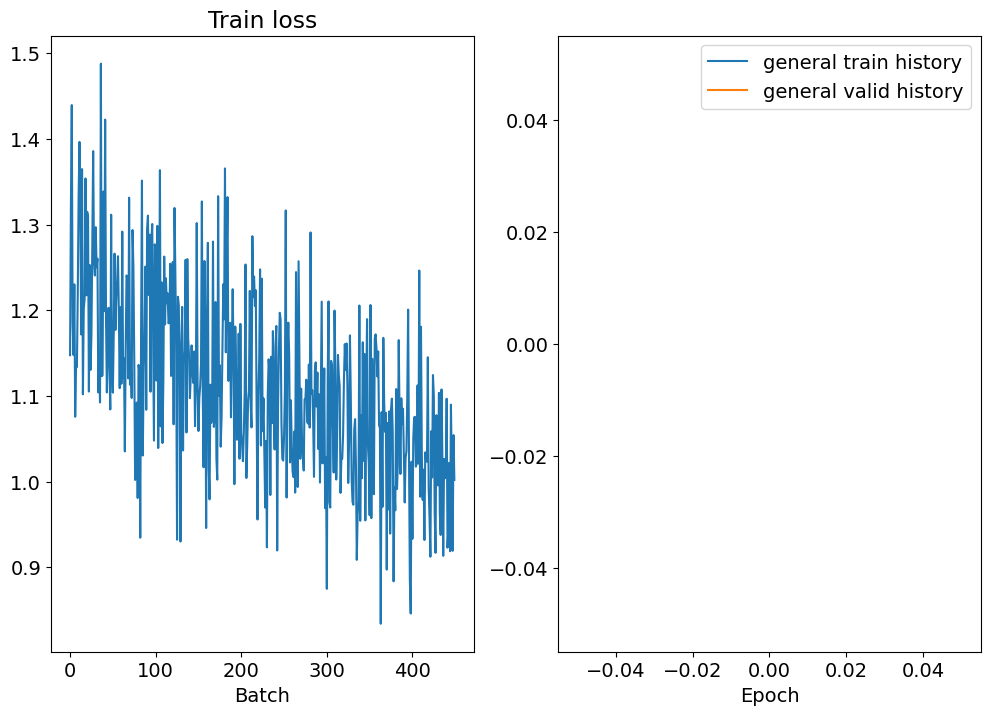

Epoch: 01 | Time: 9m 14s
	Train Loss: 0.803 | Train PPL:   2.233
	 Val. Loss: 0.691 |  Val. PPL:   1.996


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(cnn_model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(cnn_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn_model.state_dict(), 'tut1-cnn_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

As you can see in the right picture in the cell above, nothing was drawn due to the fact that there is only one epoch.

Let's change a couple of functions a little:

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten
batch = next(iter(test_iterator))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [ ]:
original_text = []
generated_text = []
cnn_model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output, _ = cnn_model(src, trg)
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

118it [00:09, 12.97it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

44.47684261202817

As we can see the result was one of the best.



### Conclusion

In this task we tried to improve the translation quality with using three different approaches/models: Attention, Transformer and CNN model. As we can see Transformer is the fastest and best performing, and showed 49.88 BLEU score. CNN model showed the second most efficient score (44.48 BLEU score). Then, also the most pleasant, which gives acceptable quality and works predictably - Attention (28.01 BLEU score).  